In [230]:
!pip install nengo

In [231]:
import nengo
import numpy as np
from nengo.processes import WhiteSignal
import matplotlib.pyplot as plt

nengo.rc.set('decoder_cache', 'enabled', 'False')

In [232]:
n_neurons = 100
dt = 0.001
T = 4.0

In [233]:
def calcuate_loss_function(real_data, predicted_data):
    return np.mean((real_data - predicted_data)**2)

In [234]:
def create_temporal_matrix(activity_data, input_data, h):
    n_samples, n_neurons_ = activity_data.shape
    assert n_samples > h, print(f'Warning: Not enough samples ({n_samples}) for history length {h}.')

    activity_temporal = np.zeros((n_samples - h, n_neurons_ * (h + 1)))
    input_temporal = input_data[h:]

    for j in range(h + 1):
        start_col = j * n_neurons_
        end_col = (j + 1) * n_neurons_
        activity_temporal[:, start_col:end_col] = activity_data[h-j:n_samples-j]
    return activity_temporal, input_temporal

In [235]:
class DelayNode:
    def __init__(self, N, delay, dt=0.001):
        self.buf_len = int(delay / dt)
        self.buffer = np.zeros((self.buf_len, N))
        self.ptr = 0

    def update(self, t, x):
        v = self.buffer[self.ptr].copy()
        self.buffer[self.ptr] = x
        self.ptr = (self.ptr + 1) % self.buf_len
        return v

In [236]:
def simulate_delay_activity(delays, run_time, dt, input_seed=56, sim_seed=45, n_neurons=100, input_high=10.0):
    with nengo.Network(seed=sim_seed) as model:
        noise = nengo.processes.WhiteSignal(period=run_time, high=input_high, rms=0.25, seed=input_seed)
        input = nengo.Node(noise, size_out=1)

        ens = nengo.Ensemble(
            n_neurons=n_neurons,
            dimensions=1,
            neuron_type=nengo.AdaptiveLIFNikol1(tau_n=0.01),
            max_rates=nengo.dists.Uniform(30, 60),
            intercepts=nengo.dists.Uniform(-0.7, 0.7),
        )
        nengo.Connection(input, ens)

        delay_probes = []
        for d in delays:
            delay = DelayNode(N=n_neurons, delay=d, dt=dt)
            delay_node = nengo.Node(
                delay.update,
                size_in=n_neurons,
                size_out=n_neurons,
                label=f"delay_{int(d*1e3)}ms"
            )
            nengo.Connection(ens.neurons, delay_node, synapse=None)
            delay_probes.append(nengo.Probe(delay_node, synapse=None, sample_every=dt))

        probe_input = nengo.Probe(input, sample_every=dt)

    with nengo.Simulator(model, seed=sim_seed) as sim:
        sim.run(run_time)
        activity = np.hstack([sim.data[p] for p in delay_probes])
        input_values = sim.data[probe_input]
        time_range = sim.trange()

    return activity, input_values, time_range

# FIR Decoding

In [237]:
delay_values = [0.02, 0.04, 0.08, 0.1]
hstacked_activity, input_values, t = simulate_delay_activity(delays=delay_values, run_time=4.0, dt=0.001, input_seed=43)
print(f'Horizontally Stacked Activity Shape: {hstacked_activity.shape}')

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Horizontally Stacked Activity Shape: (4000, 400)


In [238]:
noisy_activity = hstacked_activity + np.random.normal(
        loc=0.0,
        scale=0.5,
        size=hstacked_activity.shape
    )
actm, inpm = create_temporal_matrix(noisy_activity, input_values, 2)
print(f'input matrix shape: {inpm.shape}')
print(f'activity matrix shape: {actm.shape}')

input matrix shape: (3998, 1)
activity matrix shape: (3998, 1200)


In [239]:
coeffs, _, _, _ = np.linalg.lstsq(actm, inpm, rcond=None)
alif_decoded = actm @ coeffs

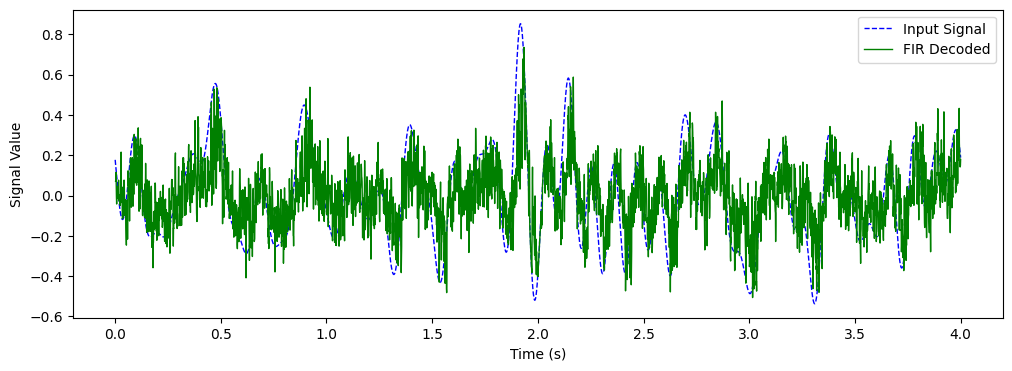

In [240]:
plt.figure(figsize=(12, 4))
plt.plot(t, input_values, label='Input Signal', color='blue', linewidth=1, linestyle='--');
plt.plot(t[2:], alif_decoded, label='FIR Decoded', color='green', linewidth=1);
plt.xlabel('Time (s)'); plt.ylabel('Signal Value'); plt.legend();

# Test on unseen results

In [241]:
hstacked_activity, input_values, t = simulate_delay_activity(delays=delay_values, run_time=4.0, dt=0.001, input_seed=453, input_high=0.5)
print(f'Horizontally Stacked Activity Shape: {hstacked_activity.shape}')

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Horizontally Stacked Activity Shape: (4000, 400)


In [242]:
actm, inpm = create_temporal_matrix(hstacked_activity, input_values, 2)
print(f'input matrix shape: {inpm.shape}')
print(f'activity matrix shape: {actm.shape}')

input matrix shape: (3998, 1)
activity matrix shape: (3998, 1200)


In [243]:
alif_decoded = actm @ coeffs

In [244]:
loss = calcuate_loss_function(input_values[2:], alif_decoded)
print(f'Loss: {loss}')

Loss: 0.03939941626544357


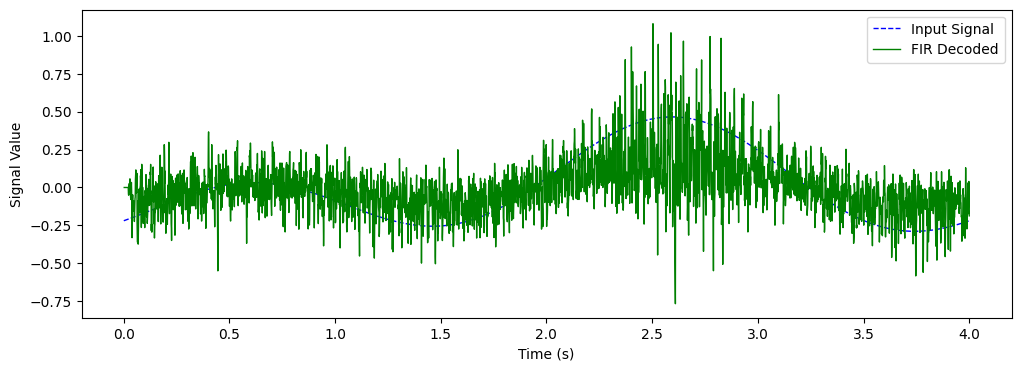

In [245]:
plt.figure(figsize=(12, 4))
plt.plot(t, input_values, label='Input Signal', color='blue', linewidth=1, linestyle='--');
plt.plot(t[2:], alif_decoded, label='FIR Decoded', color='green', linewidth=1);
plt.xlabel('Time (s)'); plt.ylabel('Signal Value'); plt.legend();